# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageEnhance

Load data

In [6]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')

In [18]:
# Set the seed for numpy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

In [8]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)

    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))

        if label == 0:
            # Rotate 180 degrees
            augmented_images.append(np.array(pil_img.rotate(180)))
            # Rotate 270 degrees
            augmented_images.append(np.array(pil_img.rotate(270)))
            # Increase the brightness
            augmented_images.append(np.array(ImageEnhance.Brightness(pil_img).enhance(1.5)))
            # Append the label for each augmented image
            augmented_labels.extend([label] * 7)
        else:
            # Append the label for each augmented image
            augmented_labels.extend([label] * 4)

    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    return augmented_images, augmented_labels

In [9]:
# Function to plot images
def plot_images(images, labels, num_images=20, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Augment data

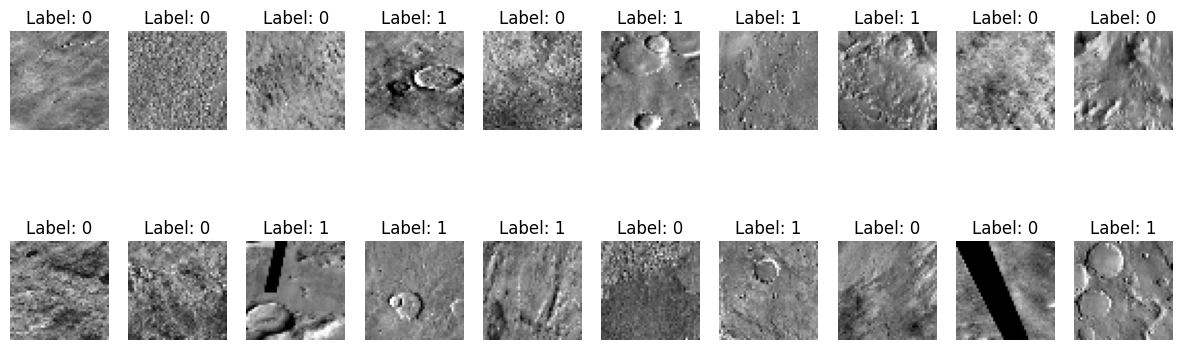

In [15]:
Xtrain_resampled, Ytrain_resampled = augment_images(Xtrain1, Ytrain1)

Xtrain_resampled_CNN = Xtrain_resampled.reshape(-1, 48, 48, 1)

# Shuffle the dataset
indices = np.arange(Xtrain_resampled_CNN.shape[0])
np.random.shuffle(indices)
Xtrain_resampled_CNN = Xtrain_resampled_CNN[indices]
Ytrain_resampled = np.array(Ytrain_resampled)[indices]

plot_images(Xtrain_resampled_CNN, Ytrain_resampled, extra=1)

## Build CNNs

### CNN

In [20]:
# Build a simple CNN model
def build_model_CNN():
    model_CNN = Sequential([
        Input(shape=(48, 48, 1)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5), # model summary

        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_CNN.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model_CNN

MLP


In [21]:
def build_model_MLP():
    model_MLP = Sequential([
        Input(shape=(2304,)),  # Flatten the input images

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_MLP.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model_MLP

## Train the models

Callbacks

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)

### CNN

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled_CNN, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

In [ ]:
# Build the CNN model
model_CNN = build_model_CNN()

# Train the model
history = model_CNN.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model_CNN.evaluate(X_val, y_val_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict on the validation set
y_val_pred = model_CNN.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_val, y_val_pred_classes)
print(f"Validation F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Reshape the data for KNN
Xtrain_knn = Xtrain_resampled.reshape(Xtrain_resampled.shape[0], -1)
Xtest_knn = Xtest1.reshape(Xtest1.shape[0], -1)

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xtrain_knn, Ytrain_resampled)

# Predict on the test set
Ytest_pred = knn_model.predict(Xtest_knn)

# Evaluate the model
accuracy = accuracy_score(Ytrain_resampled[:len(Ytest_pred)], Ytest_pred)
print(f"Accuracy of KNN model: {accuracy}")

# Save the predictions
np.save('knn_predictions.npy', Ytest_pred)

Accuracy of KNN model: 0.5301724137931034


## Evaluation of the models

### Run the model

In [9]:
# Load the best model
best_model = load_model('best_model.keras')
best_model.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_178 (Conv2D)                  │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_202              │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_178 (MaxPooling2D)     │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_179 (Conv2D)                  │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_179 (MaxPooling2D)     │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_180 (Conv2D)                  │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_204              │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_180 (MaxPooling2D)     │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_46          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,311,496 (5.00 MB)

 Trainable params: 436,866 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 873,734 (3.33 MB)

In [10]:
Xtrain1_extra = Xtrain1_extra.reshape(-1, 48, 48, 1)
predY = best_model.predict(Xtrain1_extra)
predY_classes = np.argmax(predY, axis=1)

Xtrain1_extra_resampled, Ytrain1_extra_resampled = augment_images(Xtrain1_extra, predY_classes)
Xtrain1_extra_resampled = Xtrain1_extra_resampled.reshape(-1, 48, 48, 1)

Xtrain_final = np.concatenate((Xtrain_resampled_CNN, Xtrain1_extra_resampled), axis=0)
Ytrain_final = np.concatenate((Ytrain_resampled, Ytrain1_extra_resampled), axis=0)
print(Xtrain_final.shape)
print(Ytrain_final.shape)

unique, counts = np.unique(Ytrain_final, return_counts=True)

print("Quantity of 0s:", counts[0])  # Assuming 0 is the first unique value
print("Quantity of 1s:", counts[1])  # Assuming 1 is the second unique value

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
(19791, 48, 48, 1)
(19791,)
Quantity of 0s: 11767
Quantity of 1s: 8024


In [11]:
best_f1 = model_cross_validation(Xtrain_final, Ytrain_final, "CNN", n_splits=5, epochs=100, batch_size=32)
print(f"Best F1 score: {best_f1}")

Training new fold
Epoch 1/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.8285 - loss: 0.3913 - val_accuracy: 0.8795 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 2/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8950 - loss: 0.2506 - val_accuracy: 0.7658 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 3/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9085 - loss: 0.2284 - val_accuracy: 0.5570 - val_loss: 1.7344 - learning_rate: 0.0010
Epoch 4/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9277 - loss: 0.1880 - val_accuracy: 0.6327 - val_loss: 2.0444 - learning_rate: 0.0010
Epoch 5/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9389 - loss: 0.1595 - val_accuracy: 0.6247 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 6/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9425 - loss: 0.1456 - val_accuracy: 0.8641 - val_loss: 0.3571 - learning_rate: 0.0010
Epoch 7/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accura

### Final predictions

In [55]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = best_model.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)

# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [3]:
model = load_model('best_model.keras')

In [13]:
Xtrain1 = Xtrain1.reshape(-1, 48, 48, 1)
predY = model.predict(Xtrain1)
predY_classes = np.argmax(predY, axis=1)

cm = confusion_matrix(Ytrain1, predY_classes)


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
0.9884016973125884
[[ 995   11]
 [  30 1747]]


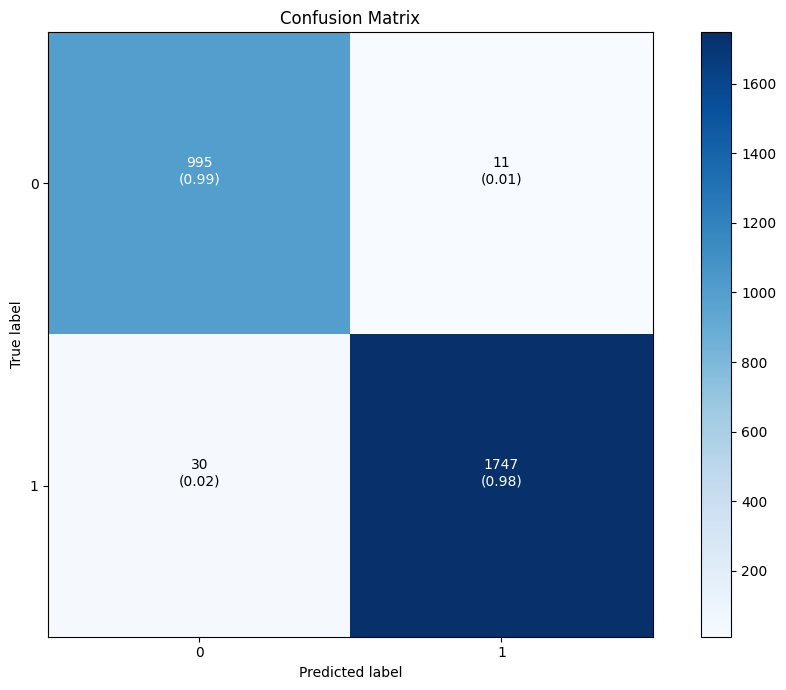

In [14]:

plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(Ytrain1)))
plt.xticks(tick_marks, np.unique(Ytrain1))
plt.yticks(tick_marks, np.unique(Ytrain1))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [4]:
ttt = np.load('predY_classes_final.npy')
print(ttt)
print(ttt.shape)

[0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0
 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0
 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1
 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0
 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0
 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1
 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1
 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0
 1 0 0 0 0 1 1 1 1 1 0 1 